In [1]:
import numpy as np

In [2]:
import pandas as pd 
import anndata as ad
import scanpy as sc

In [3]:
import screenpro as scp

In [4]:
import matplotlib.pyplot as plt

In [5]:
sc.settings.set_figure_params(dpi=150, frameon=False, figsize=(3, 3), color_map='RdGy', facecolor='white')

### 

In [25]:
meta = pd.read_excel('sample list.xlsx',index_col=0)
meta = pd.DataFrame(meta.reset_index()['Sample'].str.split(' |_').str[1:].to_list(),columns=['condition','replicate'],index=meta.Label.to_list())
meta.replicate = meta.replicate.str[-1].astype(int)

In [26]:
counts = pd.read_csv('NAC_counts.txt',sep='\t',index_col=0)

In [557]:
# pd.read_excel('NAC_screenmeasurements.xlsx',index_col=0,header=[0,1])

In [272]:
# library = pd.read_csv('CRISPRiV3_library_1_2_unbalanced.csv',index_col=0).set_index('sgID_AB')

target_df = counts[['target']].copy()
target_df['targetType'] = counts.target.apply(lambda x: "negCtrl" if x == "non-targeting" else "targeting")
target_df = target_df.sort_values('target').sort_values('targetType',ascending=False)
target_df.targetType = pd.Categorical(target_df.targetType,categories=['targeting','negCtrl'])

In [273]:
adata = ad.AnnData(
    X   = counts.loc[target_df.index,meta.index].T.astype(int),
    obs = meta,
    var = target_df
)

screen = scp.ScreenPro(adata)

In [274]:
adata.to_df().sum(axis=0).eq(0).sum()

0

In [275]:
screen.n_reps

3

In [276]:
help(screen.calculateDrugScreen)

Help on method calculateDrugScreen in module screenpro:

calculateDrugScreen(t0, untreated, treated, growth_rate, score_level) method of screenpro.ScreenPro instance
    Calculate gamma, rho, and tau phenotype scores for a drug screen dataset in a given `score_level`
    see this issue for discussion https://github.com/abearab/ScreenPro2/issues/15.
    Args:
        t0 (str): name of the untreated condition
        untreated (str): name of the untreated condition
        treated (str): name of the treated condition
        growth_rate (float): growth rate of the untreated condition
        score_level (str): name of the score level



In [558]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='NAC', growth_rate=5.406447, 
    score_level='compare_reps'
)

	vehicle vs T0
	NAC vs T0
	NAC vs vehicle


In [ ]:
screen.phenotypes['compare_reps'].to_excel('NAC_screen_results.xlsx')

## Plots

In [278]:
# screen.phenotypes['compare_reps']['tau:NAC_vs_T0']

In [279]:
almost_black = '#111111'

dark2 = ['#1b9e77',
         '#d95f02',
         '#7570b3',
         '#e7298a',
         '#66a61e',
         '#e6ab02',
         '#a6761d',
         '#666666']

### replicate scatter plots

In [280]:
def draw_scatter(adata, x, y, title, ax):
    bdata = adata[[x, y],:].copy()
    
    bdata.obs.index = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    x_lab, y_lab = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    
    sc.pp.log1p(bdata)
    sc.pl.scatter(
        bdata,
        x_lab, y_lab,
        legend_fontsize='xx-large',
        palette=[almost_black,'#BFBFBF'],
        color='targetType',
        title=title,
        size=5,
        show=False,
        ax = ax
    )
    ax.set_ylim(-1,11)
    ax.set_xlim(-1,11)
    ax.tick_params(axis='both', labelsize=10)
    ax.get_legend().remove()
    
    ax.grid(False)

In [559]:
screen.adata.obs

,condition,replicate,size_factors
TO_1_S1,T0,1,0.727538
TO_2_S2,T0,2,2.152822
TO_3_S3,T0,3,0.521350
TO_4_S4,vehicle,1,1.072814
TO_5_S5,vehicle,2,0.971792
TO_6_S6,vehicle,3,0.872361
TO_7_S7,NAC,1,1.224911
TO_8_S8,NAC,2,1.332865
TO_9_S9,NAC,3,0.775176


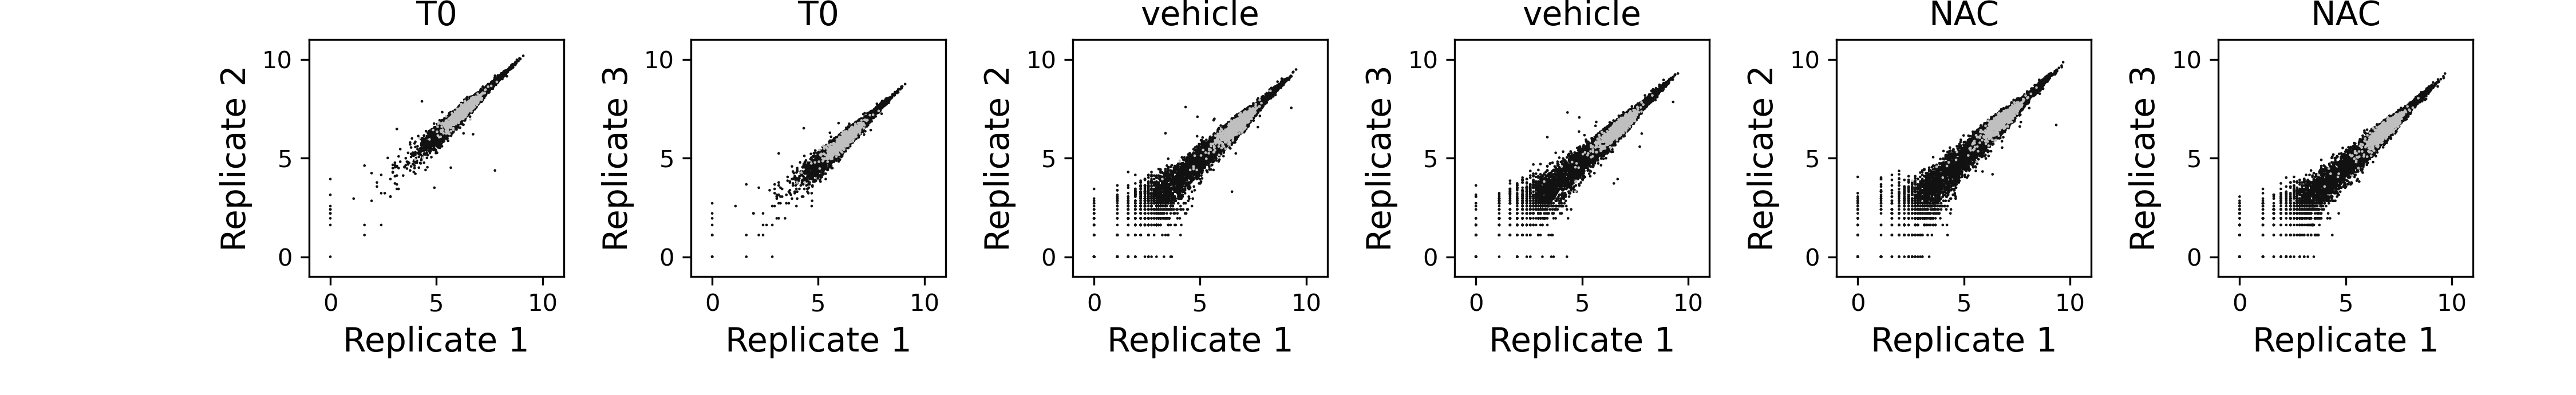

In [560]:
fig, axes = plt.subplots(ncols=6,
                         figsize=(15, 2.3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.9,'bottom':.3}, 
                         # sharey=True
                        )
draw_scatter(screen.adata, 'TO_1_S1','TO_2_S2','T0', axes[0])
draw_scatter(screen.adata, 'TO_1_S1','TO_3_S3','T0', axes[1])

draw_scatter(screen.adata, 'TO_4_S4','TO_5_S5','vehicle', axes[2])
draw_scatter(screen.adata, 'TO_4_S4','TO_6_S6','vehicle', axes[3])

draw_scatter(screen.adata, 'TO_7_S7','TO_8_S8','NAC', axes[4])
draw_scatter(screen.adata, 'TO_7_S7','TO_9_S9','NAC', axes[5])

plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

In [561]:
# screen('results/adata_counts.h5ad.gz')

In [562]:
# adata.var.index = adata.var.target

# adata.var_names_make_unique()

In [563]:
# adata.obs['group'] = adata.obs[['cell line','timepoint','treatment']].apply(' '.join,axis=1)

In [564]:
# ax = sc.pl.violin(adata, ["PRDX2","PRDX3","PRDX4","PRDX5","PRDX6"],
#              layer='log2(x+1)', 
#              groupby='group',rotation=90,size=4,
#                  )

# 
- https://chat.openai.com/share/a37004eb-50bb-491f-be7c-ce4832ec6ce3
- https://chat.openai.com/share/04047284-5811-45bf-acc4-2012c49da931

In [659]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def draw_threshold(x, threshold, pseudo_sd):
    return threshold * pseudo_sd * (1 if x > 0 else -1) / abs(x)

def prep_data(df_in,threshold=6):
    df = df_in.copy()

    df = scp.phenoScore.ann_score_df(df,threshold=threshold)

    pseudo_sd = df.loc[df['target'] == 'non-targeting', 'score'].std()

    df['-log10(pvalue)'] = np.log10(df.pvalue) * -1

    return df

def plot_volcano(ax, df_in, threshold=6, up_hit='resistance_hit', down_hit='sensitivity_hit', xlim_l=-5, xlim_r=5, ylim=6):

    df = prep_data(df_in,threshold)
    
    # Scatter plot for each category
    ax.scatter(df.loc[df['label'] == 'target_non_hit', 'score'], df.loc[df['label'] == 'target_non_hit', '-log10(pvalue)'],
               alpha=0.1, s=1, c='black', label='target_non_hit')
    ax.scatter(df.loc[df['label'] == up_hit, 'score'], df.loc[df['label'] == up_hit, '-log10(pvalue)'],
               alpha=0.9, s=1, c='#fcae91', label=up_hit)
    ax.scatter(df.loc[df['label'] == down_hit, 'score'], df.loc[df['label'] == down_hit, '-log10(pvalue)'],
               alpha=0.9, s=1, c='#bdd7e7', label=down_hit)
    ax.scatter(df.loc[df['label'] == 'non-targeting', 'score'], df.loc[df['label'] == 'non-targeting', '-log10(pvalue)'],
               alpha=0.1, s=1, c='gray', label='non-targeting')

    # Set x-axis and y-axis labels
    ax.set_xlabel('phenotype score')
    ax.set_ylabel('-log10(p-value)')

    # Set x-axis limits
    ax.set_xlim(xlim_l, xlim_r)

    # Set y-axis limits
    ax.set_ylim(0.1, ylim)

    # Add legend
    ax.legend()

def label_as_black(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=.5, t_y=-0.1):
    
    df = prep_data(df_in,threshold)
    
    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='black', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)

def label_sensitivity_hit(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=-.5, t_y=-0.1):
    
    df = prep_data(df_in,threshold)
    
    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='#3182bd', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)

def label_resistance_hit(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=.5, t_y=-0.1):

    df = prep_data(df_in,threshold)

    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='#de2d26', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)


In [660]:
# import pandas as pd
# from plotnine import ggplot, aes, geom_point, geom_text, xlab, theme, theme_classic, xlim, scale_y_continuous, ylab, stat_function


# def draw_threshold(x, threshold, pseudo_sd):
#     return threshold * pseudo_sd * (1 if x > 0 else -1) / abs(x)


# def plot_volcano(df_in, threshold=6, up_hit='resistance_hit', down_hit='sensitivity_hit', xlim_l=-5, xlim_r=5, ylim=6):
#     df = df_in.copy()
    
#     df = scp.phenoScore.ann_score_df(df,threshold=threshold)
    
#     pseudo_sd = df.loc[df['target'] == 'non-targeting', 'score'].std()
#     df['-log10(pvalue)'] = np.log10(df.pvalue) * -1

#     p = (
#         ggplot(df.dropna(), aes(x='score', y='-log10(pvalue)')) +
#         geom_point(data=df[df['label'] == 'target_non_hit'], alpha=.1,size=1, color=almost_black) +
#         geom_point(data=df[df['label'] == up_hit], alpha=.9,size=1, color='#fcae91') +
#         geom_point(data=df[df['label'] == down_hit], alpha=.9,size=1, color='#bdd7e7') +
#         geom_point(data=df[df['label'] == 'non-targeting'], alpha=.1,size=1, color='gray') +
#         xlab('phenotype score') +
#         theme_classic() +
#         xlim(xlim_l, xlim_r) +
#         scale_y_continuous(limits=(0.1, ylim)) +
#         ylab('-log10(p-value)') +
#         theme(figure_size=(3, 3))  # here you define the plot size
#     )

#     return p


# def label_as_black(p, label, size=2, t_x=5, t_y=-0.1):
#     print(p.data.query(f'target=="{label}"'))
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, colour="black", fill="black") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )


# def label_sensitivity_hit(p, label, size=2, t_x=-5, t_y=-0.1):
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, fill="#3182bd") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )


# def label_resistance_hit(p, label, size=2, t_x=5, t_y=-0.1):
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, fill="#de2d26") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )

### gamma

In [661]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

In [662]:
rho = screen.phenotypes['compare_reps']['rho:NAC_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

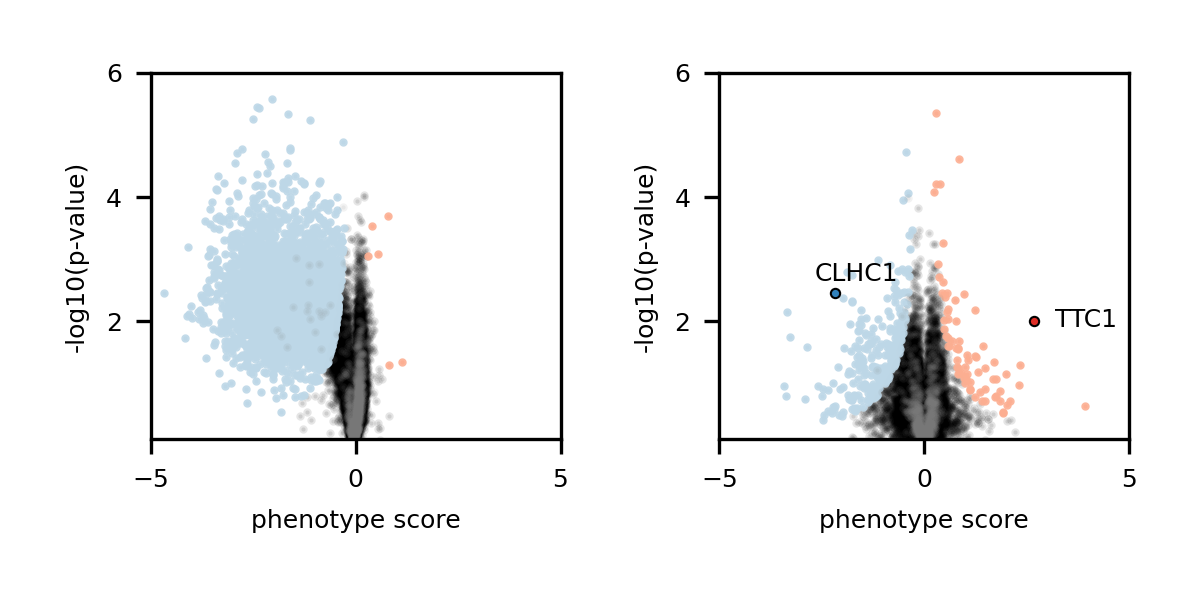

In [678]:
# Create subplots and specify the size
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(4, 2))

plot_volcano(ax1, gamma,threshold=5)
ax1.grid(False)
ax1.get_legend().remove()

plot_volcano(ax2, rho,threshold=5)
label_resistance_hit(ax2,rho,'TTC1',size=5,size_txt=6)
label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.2)


ax2.grid(False)
ax2.get_legend().remove()

for ax in [ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

plt.tight_layout()
# Show the plot
plt.show()

In [679]:
# vol.save('NAC_rho_score.pdf')

# 

In [684]:
%reload_ext watermark

In [ ]:
%watermark

Last updated: 2023-11-11T15:45:10.099320-08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [ ]:
%watermark --iversions

pandas    : 2.0.3
anndata   : 0.9.1
numpy     : 1.24.4
matplotlib: 3.7.2
screenpro : 0.2.3
scanpy    : 1.9.3



In [681]:
!date

Sat Nov 11 15:44:51 PST 2023
